# Position Encoding
In this exercise, we will look at position encoding for the Transformer architecture.

In [1]:
import torch
import torch.nn as nn

## Creating an Embedding
Consider the following vocabulary:

In [2]:
vocab = ['dog', 'cat', 'fox', 'walks', 'jumps', 'sleeps', 'and', 'the', '.', ',']
print(f'Vocab size: {len(vocab)}')

Vocab size: 10


Take a look at the [nn.Embedding documentation](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html). Create an embedding with a vocabulary size of 10 and an embedding dimension of 6.

In [3]:
emb_dim = 6
embedding = nn.Embedding(len(vocab), emb_dim)

Embed the sentence: "the dog sleeps , the cat walks and the fox jumps ."

In [4]:
sentence = "the dog sleeps , the cat walks and the fox jumps ."
words = sentence.split()
word_ids = [vocab.index(w) for w in words]
word_id_tensor = torch.LongTensor(word_ids)
emb = embedding(word_id_tensor)
print(emb.shape)
print(emb)

torch.Size([12, 6])
tensor([[-1.2439,  1.1540,  1.8428, -1.7701,  0.4793,  0.4790],
        [-0.4392,  1.5386,  1.1824, -0.4957, -1.3393,  0.6861],
        [ 0.2400, -0.9033, -1.3242, -0.0909, -1.3595, -1.1256],
        [-1.6346, -2.3229,  0.6814, -0.3558, -1.7323, -0.1215],
        [-1.2439,  1.1540,  1.8428, -1.7701,  0.4793,  0.4790],
        [ 0.3185,  0.0677, -0.6450,  0.5958, -0.6001, -0.3626],
        [-1.2169, -0.4477, -0.0208,  0.1627, -0.1855, -1.5576],
        [-0.1030, -2.1580,  0.7573, -0.9984,  0.6641, -1.6612],
        [-1.2439,  1.1540,  1.8428, -1.7701,  0.4793,  0.4790],
        [ 1.5626, -1.4380, -0.3531, -0.1345, -0.0694, -0.2986],
        [ 0.1683, -1.8672, -1.7110, -0.1136,  0.7642,  0.2629],
        [-1.6556,  1.4948,  0.2492, -0.4193, -1.0300,  0.5681]],
       grad_fn=<EmbeddingBackward0>)


## Absolute Position Encoding
The functions for absolute position encoding, as defined in [the Transformer paper](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) are as follows:

$$
\begin{align}
pos_{i, 2j} &= \sin(i / 10000^{2j/d}) \\
pos_{i, 2j+1} &= \cos(i / 10000^{2j/d})
\end{align}
$$
where $i$ is the absolute position in the sequence, and $j$ is the dimension of the embedding vector.

Create a function `absolute_position_encoding` that takes the position in the sequence $i$ and the dimension $d$ as an input and returns the position vector.

In [5]:
def absolute_position_encoding(position, dim):
    assert dim % 2 == 0, "Dimension must be even"
    pos_vector = torch.ones(dim) * position
    dim_vector = torch.arange(0, dim, 2)
    dim_vector = dim_vector / dim
    dim_vector = 10000 ** dim_vector
    pos_vector[0::2] = torch.sin(pos_vector[0::2] / dim_vector)
    pos_vector[1::2] = torch.cos(pos_vector[1::2] / dim_vector)
    pos_vector.requires_grad_(False)
    return pos_vector

Run the command below to see the values for the position vectors of the first 100 positions and the first 5 dimensions.

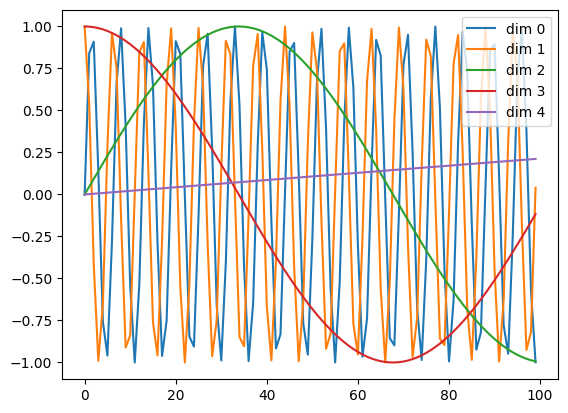

In [6]:
import matplotlib.pyplot as plt

plt.figure()
x = list(range(100))
pos_vectors = [absolute_position_encoding(i, emb_dim) for i in x]
for dim in range(5):
    y = [pv[dim].item() for pv in pos_vectors]
    plt.plot(x, y, label=f'dim {dim}')
plt.legend()
plt.show()

Apply the position encoding to the embeddings from earlier.

In [7]:
pos_emb = torch.stack([absolute_position_encoding(i, emb_dim) for i in range(len(emb))], dim=0)
x = emb + pos_emb
print(pos_emb)

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998],
        [-0.5440, -0.8391,  0.4477,  0.8942,  0.0215,  0.9998],
        [-1.0000,  0.0044,  0.4887,  0.8725,  0.0237,  0.9997]])


## Absolute Position Embedding
Write a class `AbsolutePositionEmbedding` that is initialized with a maximum length and an embedding dimension. In its `forward` method, it should take an input tensor (of shape `[batch_size, sequence_length, embedding_dim]`) and add the position embeddings to the input tensor.

In [8]:
class AbsolutePositionEmbedding(nn.Module):
    
    def __init__(self, embedding_dim, max_length=512):
        super().__init__()
        self.max_length = max_length
        self.pos_emb = nn.Embedding(max_length, embedding_dim)
    
    def forward(self, x):
        batch_size, sequence_length, _ = x.size()
        assert sequence_length <= self.max_length, "Input sequence too long"
        position_ids = torch.arange(sequence_length).unsqueeze(0)
        return x + self.pos_emb(position_ids)

Try your class with an example.

In [9]:
absolute_position_embedding = AbsolutePositionEmbedding(20, 512)
x1 = torch.randn(5, 12, 20)
x = absolute_position_embedding(x1)
x1 + x
print(x.shape)

torch.Size([5, 12, 20])


See what happens when we choose an input that is too long.

In [10]:
x2 = torch.randn(5, 1024, 20)
try:
    x = absolute_position_embedding(x2)
except AssertionError as err:
    print(err)

Input sequence too long


## Relative Position Embedding
Create a class `RelativePositionEmbedding` that is initialized with a maximum relative distance and an embedding dimension. Its `forward` method should take an input tensor of size `[batch_size, hidden_dim]` and apply the relative position embeddings given the positions $i$ of the query and $j$ of the key.

In [11]:
class RelativePositionEmbedding(nn.Module):
    
    def __init__(self, embedding_dim, max_dist=16):
        super().__init__()
        self.max_dist = max_dist
        self.dist_emb = nn.Embedding(2 * max_dist + 1, embedding_dim)  # -max_dist, ..., -1, 0, 1, ..., max_dist
    
    def forward(self, x, i, j):
        dist = i - j + self.max_dist  # map [-max_dist, max_dist] to [0, 2*max_dist]
        dist = max(0, min(2*self.max_dist, dist))  # distance is bounded by [0, 2*max_dist]
        return x + self.dist_emb(torch.tensor(dist)).unsqueeze(0)

Try it with an example.

In [12]:
rel_pos_emb = RelativePositionEmbedding(20, 16)
x = torch.randn(5, 20)
result = rel_pos_emb(x, 0, 3)
result = rel_pos_emb(x, 49, 15)
print(result.shape)

torch.Size([5, 20])


**Question:** Where would we use this module?

**Answer:** During the computation of the attention function. It is applied to the key tensor before the scaled dot-product attention. Since the key tensor is split into heads at that point, the `embedding_dim` of the `RelativePositionEmbedding` module should be the `hidden_dim` divided by the number of attention heads.

**Question:** Look at the HuggingFace implementation of relative position embeddings in the BERT model:
- [initialization from line 244](https://github.com/huggingface/transformers/blob/v4.46.0/src/transformers/models/bert/modeling_bert.py#L244)
- [forward method from line 320](https://github.com/huggingface/transformers/blob/v4.46.0/src/transformers/models/bert/modeling_bert.py#L320)

Describe what their `relative_key` method does differently from the [Shaw et al. (2018)](https://aclanthology.org/N18-2074/) paper we saw in the lecture.

**Answer:**
- Their `max_dist` is the maximum input length (default: 512). They don't truncate the relative position distance at a smaller value.
- They use an efficient vectorized implementation where they compute the distance values for all combinations of $i$ and $j$, then perform a matrix multiplication of the query and the relative position embedding tensors.

Note: The matrix multiplication of the relative position embeddings with the query layer comes from using the distributive law on the numerator of the attention function with relative positions: $q_i(k_j + \text{pos}_{i-j})^\top = q_i k_j^\top + q_i \text{pos}_{i-j}^\top$.